#<font color="red">
Download Dataset. Copy the API Command of any Dataset and Paste it here</font>

In [ ]:
!kaggle datasets download -d khoongweihao/covid19-xray-dataset-train-test-sets

 96% 81.0M/84.3M [00:03<00:00, 25.7MB/s]
100% 84.3M/84.3M [00:03<00:00, 24.5MB/s]


###<font color="red">Unzip Dataset</font>

In [ ]:
!unzip /content/covid19-xray-dataset-train-test-sets.zip

Archive:  /content/covid19-xray-dataset-train-test-sets.zip
replace xray_dataset_covid19/test/NORMAL/NORMAL2-IM-0035-0001.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: xray_dataset_covid19/test/NORMAL/NORMAL2-IM-0035-0001.jpeg  
  inflating: xray_dataset_covid19/test/NORMAL/NORMAL2-IM-0052-0001.jpeg  
  inflating: xray_dataset_covid19/test/NORMAL/NORMAL2-IM-0058-0001.jpeg  
  inflating: xray_dataset_covid19/test/NORMAL/NORMAL2-IM-0059-0001.jpeg  
  inflating: xray_dataset_covid19/test/NORMAL/NORMAL2-IM-0072-0001.jpeg  
  inflating: xray_dataset_covid19/test/NORMAL/NORMAL2-IM-0073-0001.jpeg  
  inflating: xray_dataset_covid19/test/NORMAL/NORMAL2-IM-0092-0001.jpeg  
  inflating: xray_dataset_covid19/test/NORMAL/NORMAL2-IM-0105-0001.jpeg  
  inflating: xray_dataset_covid19/test/NORMAL/NORMAL2-IM-0110-0001.jpeg  
  inflating: xray_dataset_covid19/test/NORMAL/NORMAL2-IM-0111-0001.jpeg  
  inflating: xray_dataset_covid19/test/NORMAL/NORMAL2-IM-0112-0001.jpeg  
  inflating: xray_

#<font color="red">Now Start the Project</font>

In [ ]:
!pip install jcopdl==1.1.10
!pip install gdown

  Preparing metadata (setup.py) ... done
  Created wheel for jcopdl: filename=jcopdl-1.1.10-py2.py3-none-any.whl size=17912 sha256=924ef4c02092a9d4ec6706d2b7d2312a5054dfb52671496a38c52353c723564c
  Stored in directory: /root/.cache/pip/wheels/41/95/30/86345d2446be19c7d97dee789a2597bee81cfbb7b24a847f7c
Successfully built jcopdl


In [ ]:
import jcopdl
jcopdl.__version__

'1.1.10'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

#<font color="red">Dataset & Dataloader</font>

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
#from jcopdl.utils.dataloader import MultilabelDataset

In [ ]:
bs = 128
crop_size = 128

train_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(crop_size, scale=(0.7, 1.0)),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(140),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor()
])

train_set = datasets.ImageFolder("xray_dataset_covid19/train/", transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=4)

test_set = datasets.ImageFolder("xray_dataset_covid19/test/", transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
images, labels = next(iter(trainloader))
images.shape, labels.shape

(torch.Size([128, 3, 128, 128]), torch.Size([128]))

In [ ]:
label2cat = train_set.classes
label2cat

['NORMAL', 'PNEUMONIA']

#<font color="red">Architecture & Config</font>

###<font color="red">Custom CNN</font>

In [ ]:
from jcopdl.layers import conv_block, linear_block

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            conv_block(3, 8),
            conv_block(8, 16),
            conv_block(16, 32),
            conv_block(32, 64),
            conv_block(64, 128),
            nn.Flatten()
        )

        self.fc = nn.Sequential(
            linear_block(128*4*4, 256, dropout=0.1),
            linear_block(256, 2, activation="lsoftmax")
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

In [ ]:
config = set_config({
    'batch_size': bs,
    'crop_size': crop_size,
    'labels': label2cat
})

###<font color="red">Phase 1: Training Preparation (MCOC)</font>

In [ ]:
model = CNN().to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="model")

In [ ]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)

        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc

Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 0.5308 | Test_cost  = 0.4684 | Train_score = 0.8311 | Test_score = 0.7500 |
==> EarlyStop patience =  2 | Best test_score: 0.8500


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 0.4119 | Test_cost  = 0.5119 | Train_score = 0.8176 | Test_score = 0.7000 |
==> EarlyStop patience =  3 | Best test_score: 0.8500


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 0.3950 | Test_cost  = 0.3167 | Train_score = 0.8108 | Test_score = 0.9000 |


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 0.2901 | Test_cost  = 0.2992 | Train_score = 0.8919 | Test_score = 0.9000 |
==> EarlyStop patience =  1 | Best test_score: 0.9000


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 0.2413 | Test_cost  = 0.3850 | Train_score = 0.9324 | Test_score = 0.7750 |
==> EarlyStop patience =  2 | Best test_score: 0.9000


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    14
Train_cost  = 0.3321 | Test_cost  = 0.3340 | Train_score = 0.8716 | Test_score = 0.8750 |
==> EarlyStop patience =  3 | Best test_score: 0.9000


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    15
Train_cost  = 0.2839 | Test_cost  = 0.2448 | Train_score = 0.8784 | Test_score = 0.8750 |
==> EarlyStop patience =  4 | Best test_score: 0.9000


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a15aad8a8c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a15aad8a8c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Train:   0%|          | 0/2 [00:10<?, ?it/s]

: can only test a child process
Exception in thread Exception ignored in: <function _releaseLock at 0x7a168aa72440>
Traceback (most recent call last):
  File "/usr/lib/python3.10/logging/__init__.py", line 228, in _releaseLock
    def _releaseLock():
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/signal_handling.py", line 66, in handler
    _error_if_any_worker_fails()
RuntimeError: DataLoader worker (pid 6235) is killed by signal: Aborted. 


Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    16
Train_cost  = 0.2823 | Test_cost  = 0.2678 | Train_score = 0.8986 | Test_score = 0.9000 |
==> EarlyStop patience =  5 | Best test_score: 0.9000
==> Execute Early Stopping at epoch: 16 | Best test_score: 0.9000
==> Best model is saved at model


Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 361, in

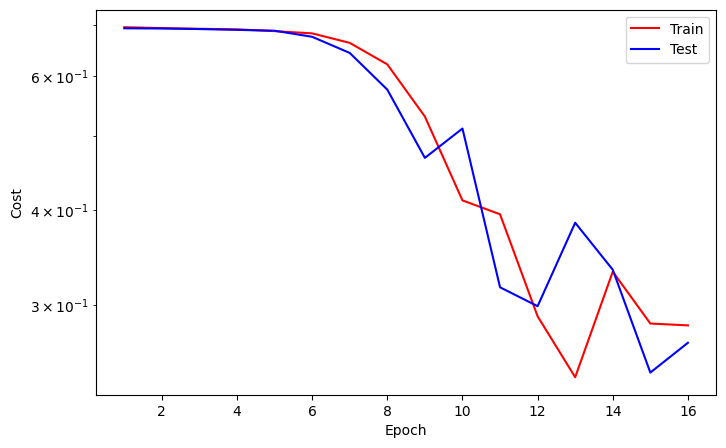

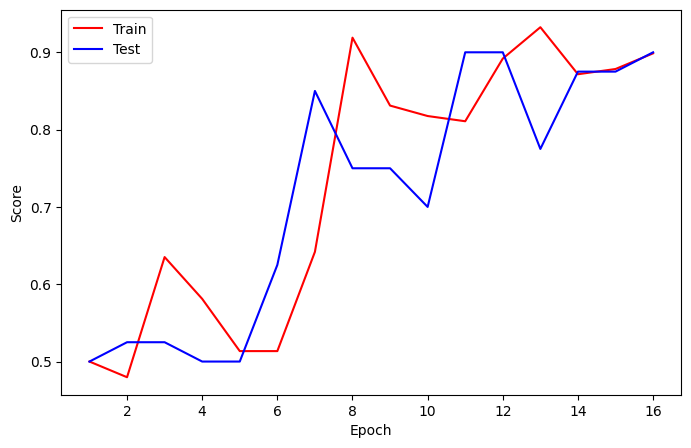

In [ ]:
while True:
    train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost, test_score = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)

    # Logging
    callback.log(train_cost, test_cost, train_score, test_score)

    # Checkpoint
    callback.save_checkpoint()

    # Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()

    # Early Stopping
    if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
        break

###<font color="red">Predict</font>

In [ ]:
images, labels = next(iter(testloader))
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    model.eval()
    output = model(images)
    preds = output.argmax(1)
preds

tensor([1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1,
        1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0])

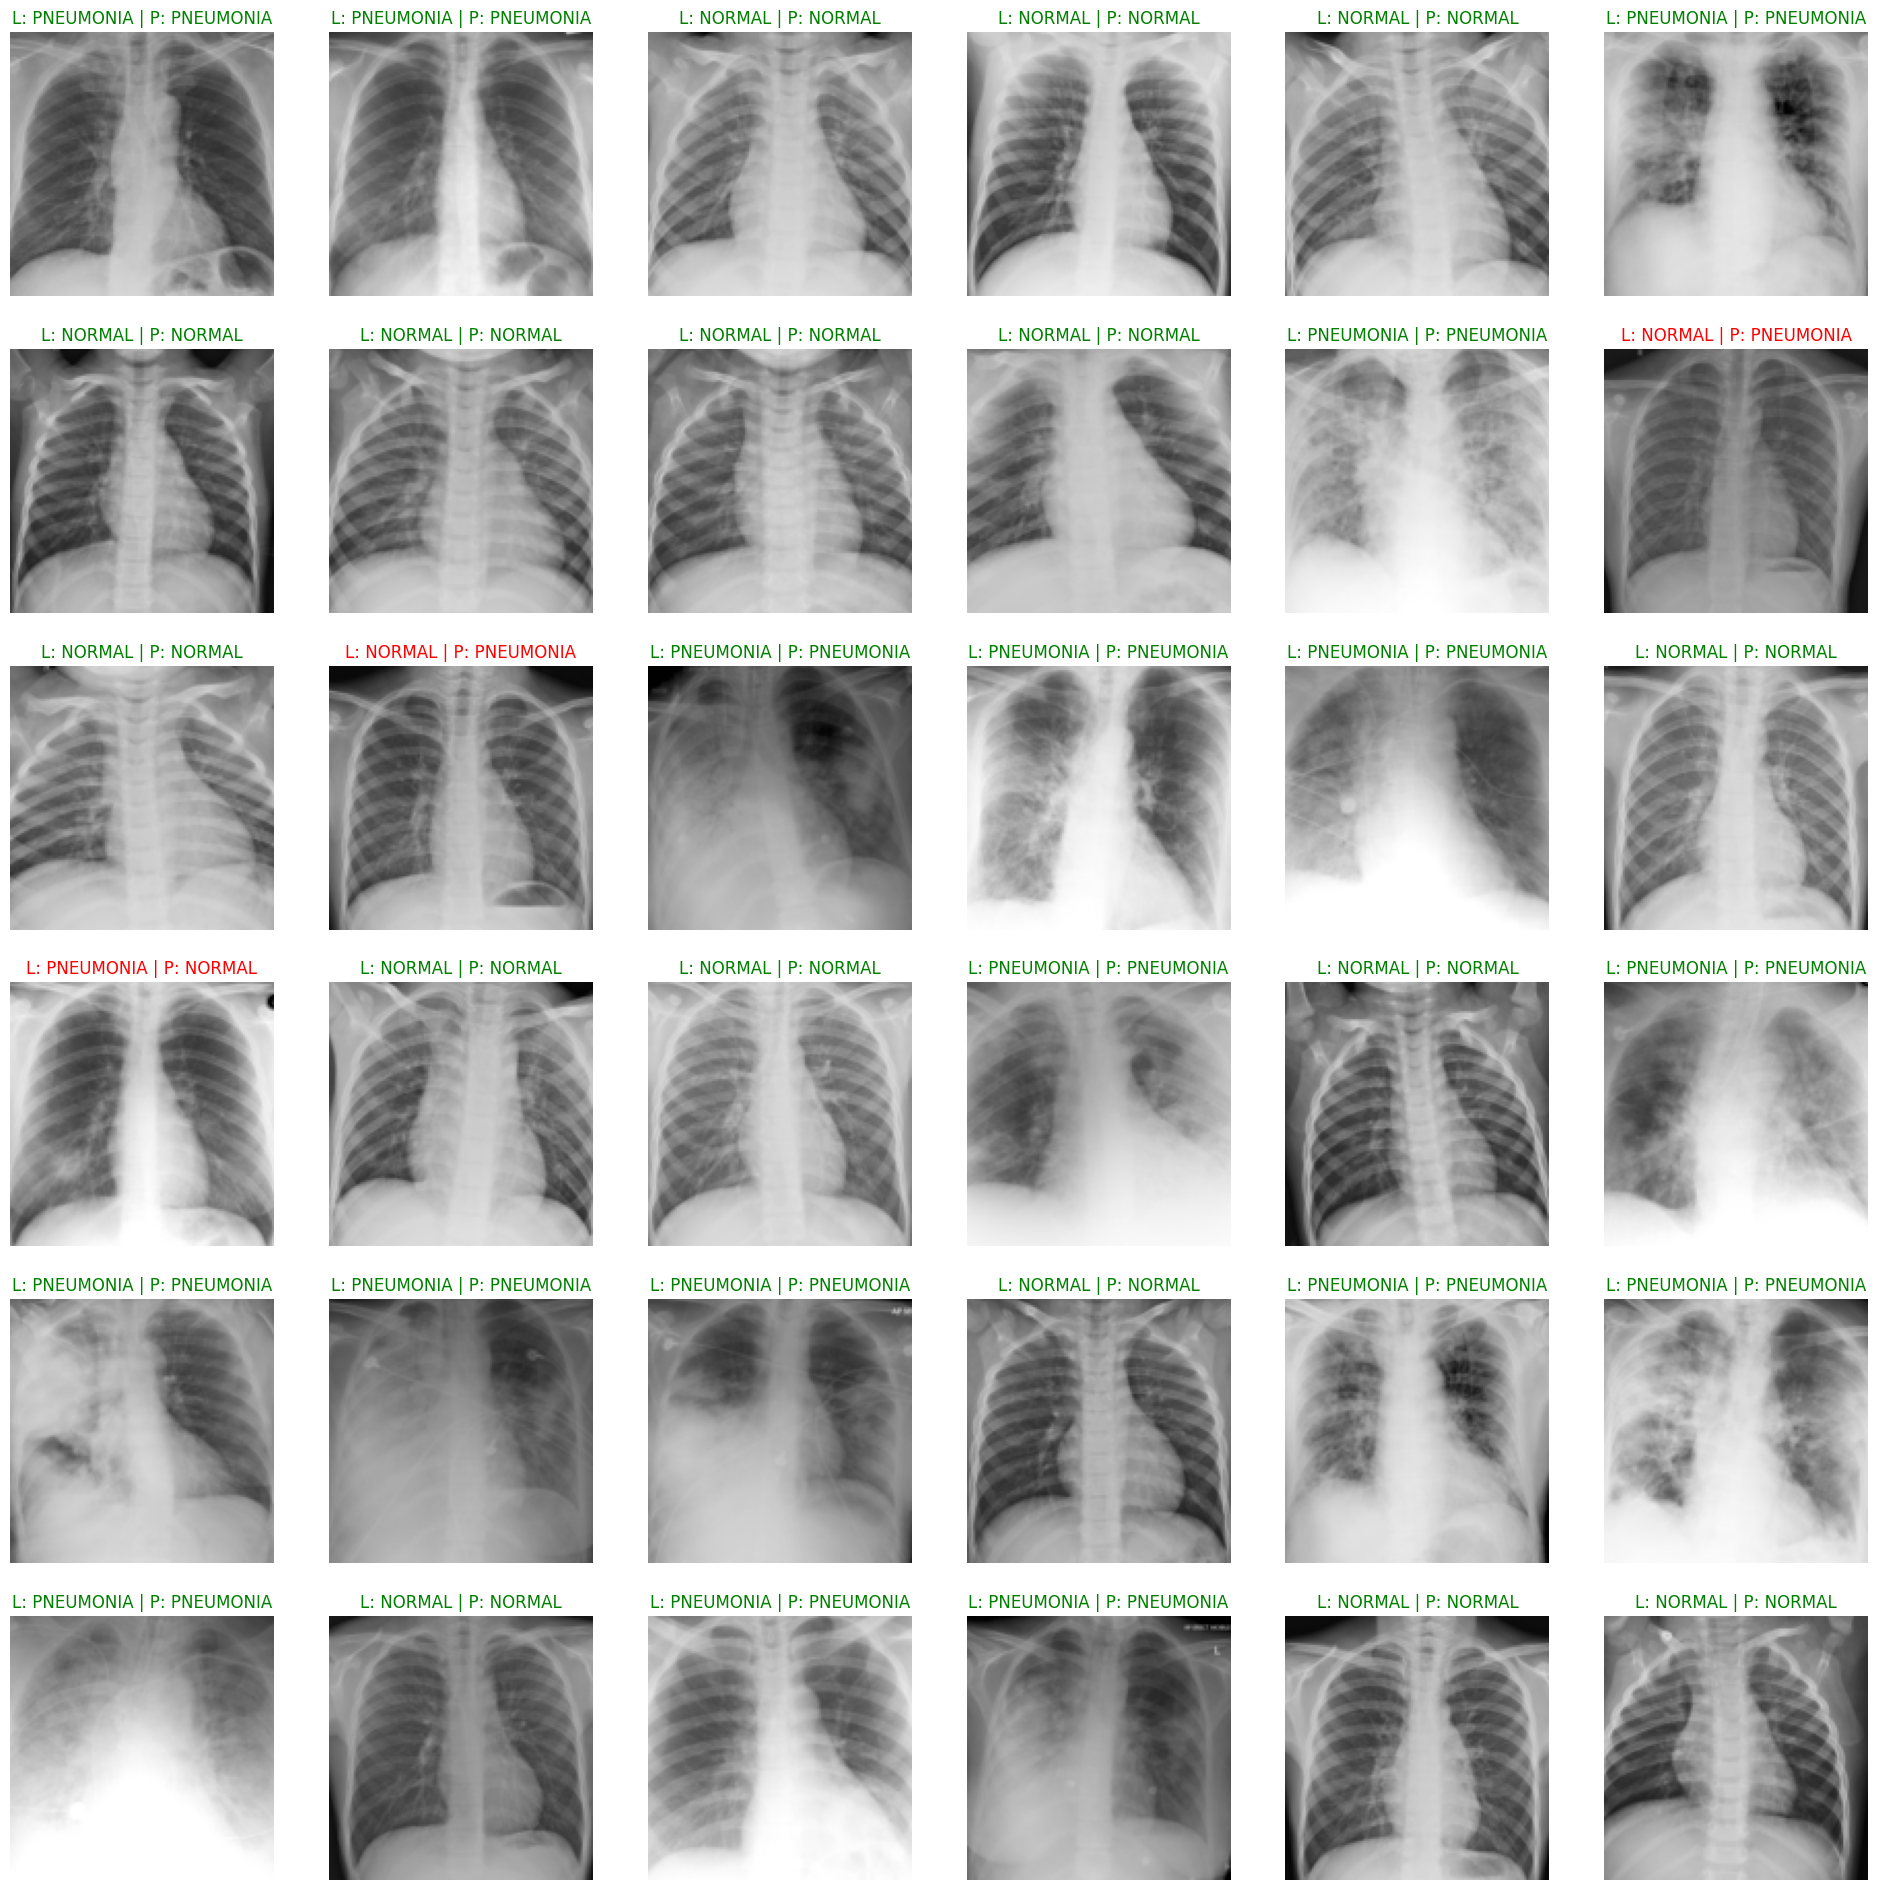

In [ ]:
ig, axes = plt.subplots(6, 6, figsize=(24, 24))
for image, label, pred, ax in zip(images, labels, preds, axes.flatten()):
    ax.imshow(image.permute(1, 2, 0).cpu())
    font = {"color": 'r'} if label != pred else {"color": 'g'}
    label, pred = label2cat[label.item()], label2cat[pred.item()]
    ax.set_title(f"L: {label} | P: {pred}", fontdict=font);
    ax.axis('off');

In [ ]:
list_prediction = [0 if label != pred else 1 for label, pred in zip(labels, preds)]

accuracy = sum(list_prediction)/len(list_prediction)

print(f"\033[1m \033[91m Correctly Predict {sum(list_prediction)} Out Of {len(list_prediction)}")
print(f" The accuracy is: {accuracy*100} % \033[1m \033[91m ")

  Correctly Predict 36 Out Of 40
 The accuracy is: 90.0 %   
